In [2]:
import particles
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import mcmc
from particles import smc_samplers as ssp
from particles.collectors import Moments
from math import inf

# Read data

(5000, 6)


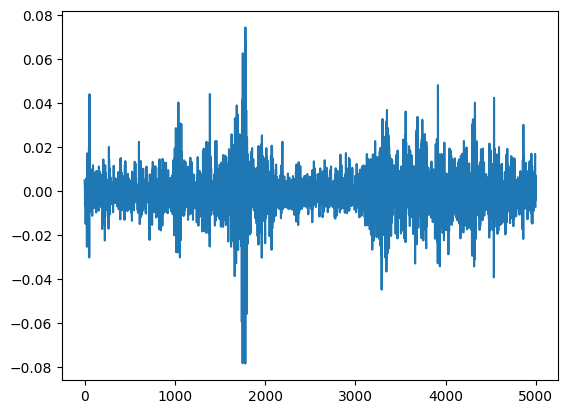

In [3]:
# annualization conversion
YEAR_SCALE = 252
# read the datafile
data = pd.read_csv("data.csv")
print(data.shape)

# pull out the relevant columns as np arrays
price = np.array(data.sp500_price)
zero_risk = np.array(data.zr_yield)
div_yield = np.array(data.sp500_yield)

# returns is log of daily price increase
returns = np.log(price[1:] / price[:-1])
# need to normalize these from yearly to daily rate
# but, the sp500 is only open on weekdays
# and there are about 252 weekdays in a year
r = np.log(zero_risk[:-1]) / YEAR_SCALE
delta = np.log(div_yield[:-1]) / YEAR_SCALE

returns_mu = r - delta

returns_var = returns - returns_mu

# let's look at the data
plt.figure()
plt.plot(returns_var)
plt.show()

# Models

In [4]:
# The authors of the paper write that they use the following prior for $rho$:
# log ((rho + 1)/(1 - rho)) ~ N(-1.5, 0.5).
# This is basically the inverse logit, which the Distributions package doesn't seem to provide.
class InvLogitD(dists.TransformedDist):
    """Distribution of Y = (e^x - 1)/(e^x + 1)."""
    def __init__(self, base_dist):
        self.base_dist = base_dist
        
    def f(self, x):
        xp = np.exp(x)
        return (xp - 1)/(xp + 1)

    def finv(self, x):
        # should return infs here...
        return np.log((x + 1)/(1 - x))

    def logJac(self, x):
        return -np.log((1 - x*2)/2.)

Heston model: the simpler version of an SVCJ.

In [8]:
class HestonVol(ssm.StateSpaceModel):
    """
    SV Model of Heston
    """

    default_params = {
        "kappa": 1.0,
        "theta": 0.0,
        "sigma": 1.0,
        "rho": -1.0,
        "eta_s": 1.0,
    }

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def PX0(self):
        V_prev_dist = dists.Dirac(loc=self.theta)
        W = dists.Normal()

        return dists.IndepProd(V_prev_dist, W)

    def PX(self, t, xp): # Distribution of X_t given X_{t-1}=xp (p=past)
        # the hidden state is NOT (V_t, w_t, )!
        # rather, it is           (V_{t-1}, w_t)
        V_prev, W_prev = xp.T

        # Compute V_{t-1}
        V = (
            V_prev
            + self.kappa * (self.theta - V_prev)
            + self.sigma * np.sqrt(V_prev) * W_prev
        )
        # keep it above zero
        # if 2 kappa theta > sigma^2, then the *continous* process stays positive.
        # but the discretized process can still end up negative.
        V = np.maximum(V, 0)

        # rather than calculate the distribution for V_t, we'll compute V_{t-1} and save that
        # and V_t can be computed on the next iteration, after drawing from the distributions for
        V_dist = dists.Dirac(loc=V)

        # all of these distributions are constant and independant
        W = dists.Normal()

        return dists.IndepProd(V_dist, W)

    def PY(self, t, xp, x): # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        # we don't need xp: x contains (V_{t_1}, w_t, B_t, etc.)
        V_prev, W = x.T

        mu = V_prev * (self.eta_s - 0.5)
        # R_{t+1} = mu + sqrt(v_t) z
        # where z and w are N(0, 1) with correlation rho
        # hence z|w ~ N(rho * w, (1 - rho^2))
        # and so R|(w, v) ~ N(mu + sqrt(v) rho w, v_t (1 - rho^2))
        # distributions package expect sigma, not sigma^2
        sqv = np.sqrt(V_prev)
        return dists.Normal(
            loc=mu + sqv * self.rho * W, scale=sqv * np.sqrt(1 - self.rho**2)
        )

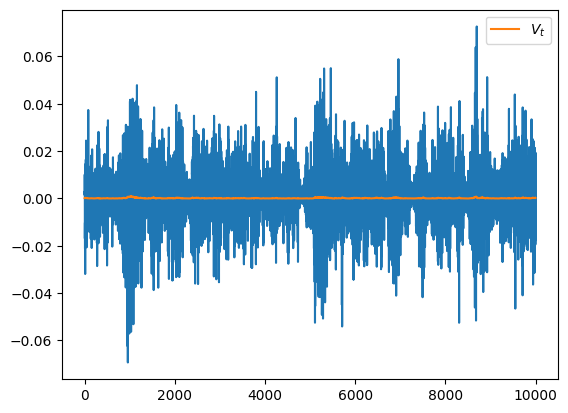

In [9]:
heston_theta = {
    "kappa": 2.0 / YEAR_SCALE, 
    "theta": 0.035 / YEAR_SCALE,
    "sigma": 0.38 / YEAR_SCALE,
    "rho": -0.9,
    "eta_s": 1.0
}

# Generate some data from the Heston model to make sure the parameters look like the true parameters
heston_model = HestonVol(**heston_theta)

heston_states, heston_data = heston_model.simulate(10000)

heston_states = np.asarray(heston_states).squeeze()

plt.figure()
plt.plot(heston_data)
plt.plot(heston_states[:, 0], label="$V_t$")
plt.legend()
plt.show()

## SVCJ

SVCJ is the full-complexity model.

In [10]:
class SVCJ(ssm.StateSpaceModel):
    """
    Model with correlated return and variance jumps.
    """

    default_params = {
        "kappa": 1.0,
        "theta": 0.0,
        "sigma": 1.0,
        "rho": -1.0,
        "eta_s": 1.0,
        "lam": 0.5,
        "mu_s": 0.0,
        "sigma_s": 1.0,
        "mu_v": 0.0,
        "rho_j": 0.0,
    }

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mubar_s = (
            np.exp(self.mu_s + self.sigma_s**2 / 2) / (1 - self.rho_j * self.mu_v) - 1
        )
        # clamp some parameters...
        self.lam = max(min(self.lam, 1.0), 0)

    def PX0(self):
        V_prev_dist = dists.Dirac(loc=self.theta)
        w = dists.Normal()
        B = dists.Binomial(n=1, p=self.lam)
        # This gives an exponential distribution
        Jv = dists.Gamma(a=1, b=self.mu_v)
        Js_minus_rho_jv = dists.Normal(loc=self.mu_s, scale=self.sigma_s)

        return dists.IndepProd(V_prev_dist, w, B, Jv, Js_minus_rho_jv)

    def PX(self, t, xp):
        # the hidden state is NOT (V_t, w_t, B_t, Jv_t, Js_t)!
        # rather, it is           (V_{t-1}, ...)
        (V_prev_prev, w_prev, B_prev, Jv_prev, Js_minus_rho_jv_prev) = xp.T

        # Compute V_{t-1}
        V_prev = (
            V_prev_prev
            + self.kappa * (self.theta - V_prev_prev)
            + self.sigma * np.sqrt(V_prev_prev) * w_prev
            + Jv_prev * B_prev
        )
        # keep it above zero
        # if 2 kappa theta > sigma^2, then the *continous* process stays positive.
        # but the discretized process can still end up negative.
        V_prev = np.maximum(V_prev, 0)

        # rather than calculate the distribution for V_t, we'll compute V_{t-1} and save that
        # and V_t can be computed on the next iteration, after drawing from the distributions for
        V_prev_dist = dists.Dirac(loc=V_prev)

        # all of these distributions are constant and independant
        w = dists.Normal()
        B = dists.Binomial(n=1, p=self.lam)
        # This gives an exponential distribution
        Jv = dists.Gamma(a=1, b=self.mu_v)
        Js_minus_rho_jv = dists.Normal(loc=self.mu_s, scale=self.sigma_s)

        return dists.IndepProd(V_prev_dist, w, B, Jv, Js_minus_rho_jv)

    def PY(self, t, xp, x):
        # we don't need xp: x contains (V_{t_1}, w_t, B_t, etc.)
        (V_prev, w, B, Jv, Js_minus_rho_jv) = x.T
        Js = Js_minus_rho_jv + self.rho_j * Jv

        mu = (
            - self.lam * self.mubar_s
            + V_prev * (self.eta_s - 0.5)
            + Js * B
        )
        # R_{t+1} = mu + sqrt(v_t) z
        # where z and w are N(0, 1) with correlation rho
        # hence z|w ~ N(rho * w, (1 - rho^2))
        # and so R|(w, v) ~ N(mu + sqrt(v) rho w, v_t (1 - rho^2))
        # distributions package expect sigma, not sigma^2
        sqv = np.sqrt(V_prev)
        return dists.Normal(
            loc=mu + sqv * self.rho * w, scale=sqv * np.sqrt(1 - self.rho**2)
        )

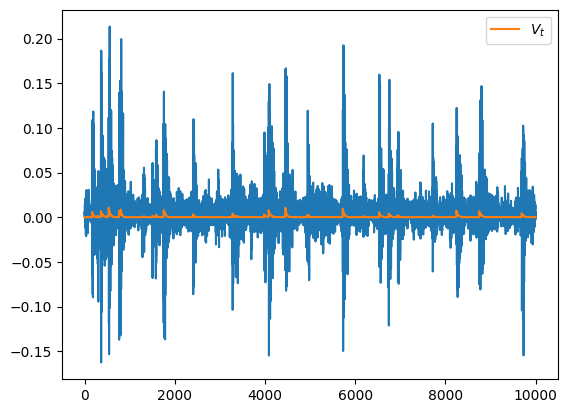

In [26]:
# now we'll try initializing a SVCJ, using the parameters obtained in the paper
# based on data only from returns (Table A1)

# they say "parameters are annualized? what does this mean..."
# I think this means that in the original differential equation, one unit of time is equal to a year.
# In the discretization, some parameters need to be scaled.

# I'm also especially unsure about lambda. It's the probability for a Bernoulli,
# which represents the discretization a Poisson point process with rate lambda...
svcj_theta = {
    "kappa": 7.4 / YEAR_SCALE,
    "theta": 0.02 / YEAR_SCALE,
    "sigma": 0.4 / YEAR_SCALE,
    "rho": -0.82,
    "eta_s": 3.25,
    "lam": 0.8 / YEAR_SCALE,
    "mu_s": -0.02 / YEAR_SCALE,
    "sigma_s": 0.02 / YEAR_SCALE,
    "mu_v": YEAR_SCALE,
    "rho_j": -0.09,
}

# Generate some data from the Heston model to make sure the parameters look like the true parameters
svcj_model = SVCJ(**svcj_theta)

svcj_states, svcj_data = svcj_model.simulate(10000)
svcj_states = np.asarray(svcj_states).squeeze()

plt.figure()
plt.plot(svcj_data)
plt.plot(svcj_states[:, 0], label="$V_t$")
plt.legend()
plt.show()

# PMMH

In [ ]:
# Use PMMH to estimate Heston parameters
heston_dict = {
    "kappa": dists.Uniform(1e-4, 5e-2),
    "theta": dists.Uniform(0, 3e-4),
    "sigma": dists.Uniform(1e-4, 1e-2),
    "rho": dists.Uniform(-1, 1),#InvLogitD(dists.Normal(-1.5, 0.5)),
    "eta_s": dists.Uniform(0.1, 5)
}
heston_prior = dists.StructDist(heston_dict)

chains = []
for i in range(10):
    print(i)
    heston_pmmh = mcmc.PMMH(ssm_cls=HestonVol, prior=heston_prior, data=returns_var, Nx=300, niter=300)
    heston_pmmh.run()
    chains.append(heston_pmmh.chain)

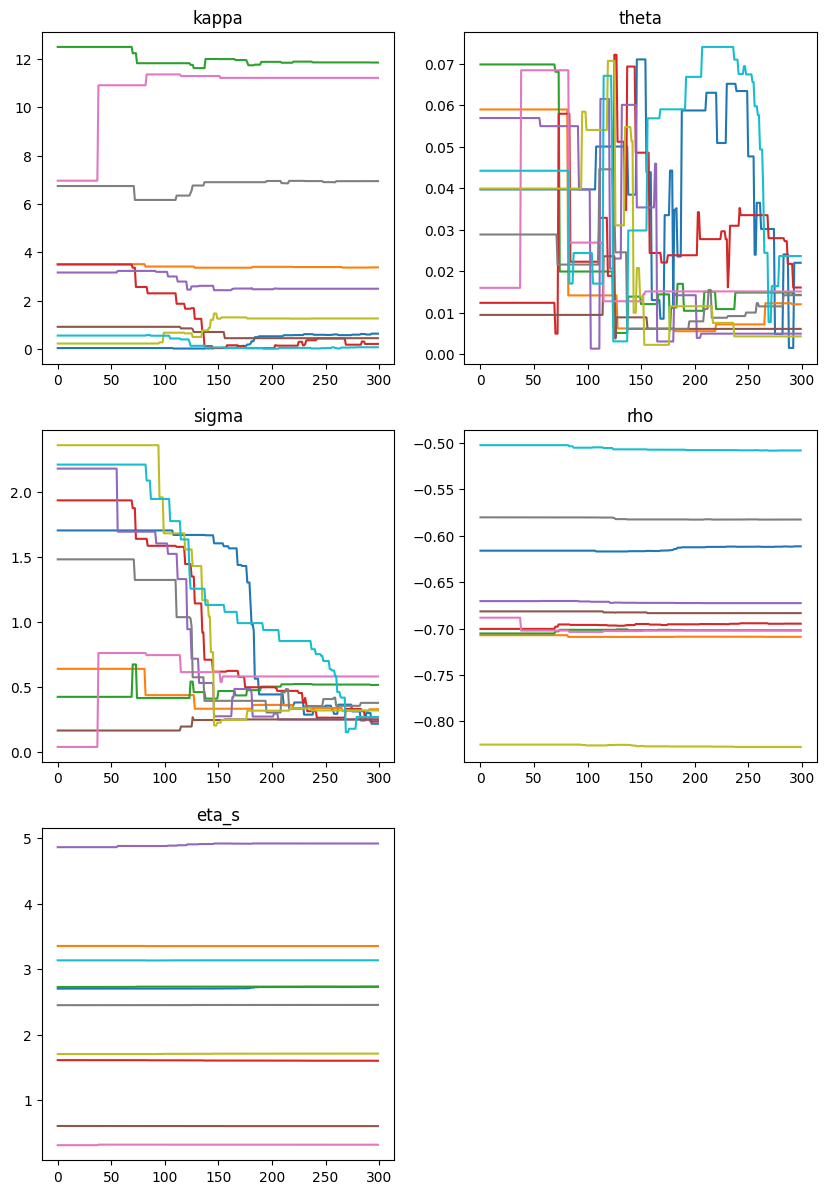

In [183]:
plt.figure(figsize=(10,25))
for i, param in enumerate(heston_theta.keys()):
    scale = YEAR_SCALE if param in ['kappa', 'theta', 'sigma'] else 1
    plt.subplot(5, 2, i+1)
    plt.title(param)
    for ch in chains:
        plt.plot(ch.theta[param] * scale)
    #sns.histplot(svcj_pmmh.chain.theta[param], kde=True)
plt.show()

In [193]:
svcj_prior = dists.StructDist({
     "kappa": dists.Uniform(1e-4, 5e-2),
    "theta": dists.Uniform(0, 3e-4),
    "sigma": dists.Uniform(1e-4, 1e-2),
    "rho": InvLogitD(dists.Normal(-1.5, 0.5)),
    "eta_s": dists.Uniform(-1, 1),
    "lam": dists.LinearD(InvLogitD(dists.Normal(-6, 1)), a = 1/(2*YEAR_SCALE), b=1/(2 * YEAR_SCALE)),
    "mu_s": dists.Uniform(-0.1, 0.1),
    "sigma_s": dists.Uniform(0, 0.1),
    "mu_v": dists.Uniform(1, 1000),
    "rho_j": InvLogitD(dists.Normal(-0.5, 0.5)),
})
schains = []
for i in range(10):
    svcj_pmmh = mcmc.PMMH(ssm_cls=SVCJ, prior=svcj_prior, data=returns_var, Nx=200, niter=250)
    svcj_pmmh.run()
    schains.append(svcj_pmmh.chain)

/tmp/ipykernel_26401/3681197585.py:15: RuntimeWarning: invalid value encountered in log
  return np.log((x + 1)/(1 - x))
/tmp/ipykernel_26401/3681197585.py:18: RuntimeWarning: invalid value encountered in log
  return -np.log((1 - x*2)/2.)


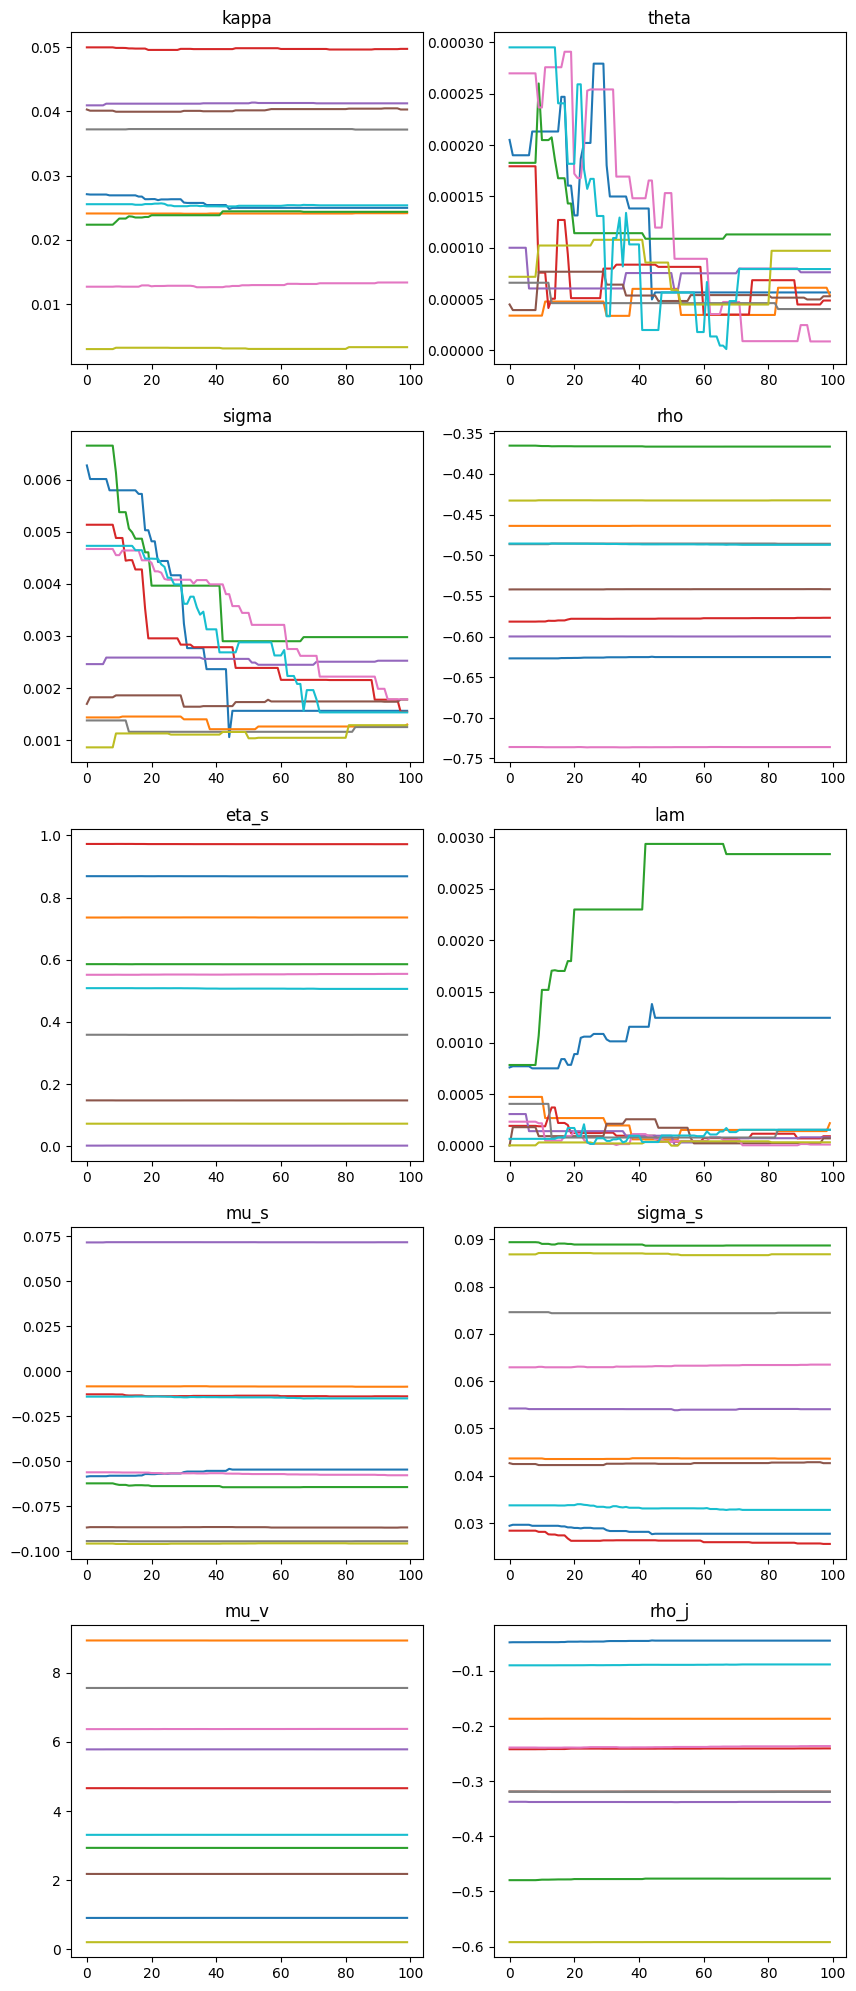

In [195]:
plt.figure(figsize=(10,25))
for i, param in enumerate(params_article.keys()):
    plt.subplot(5, 2, i+1)
    for sch in schains:
        plt.plot(sch.theta[param][150:] * scale)
    plt.title(param)
plt.show()

In [205]:
# Get the mean of each estimated distribution
for param in params_article.keys():
    tot = 0
    for sch in schains:
        tot += np.mean(sch.theta[param][150:])
    avg = tot / len(schains)
    if param in ['kappa', 'theta', 'sigma', 'lam', 'sigma_s']:
        avg *= YEAR_SCALE
    print(f"{param}: {avg}")

kappa: 7.144834215217405
theta: 0.021790261195667626
sigma: 0.5948397649243453
rho: -0.5316995436320653
eta_s: 0.4800312651865859
lam: 0.11053428762291934
mu_s: -0.04191319064423053
sigma_s: 13.643255243393936
mu_v: 4.282718578430528
rho_j: -0.2846689009142731
